In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import cm
from matplotlib import pyplot as plt

# '"text.usetex": True' causes  runtime errors when plotting.
plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "sans-serif",
#    "font.sans-serif": "Computer Modern",
    "font.size": 22})


#import numpy as np
from scipy import integrate as integrate
import math

from astropy.cosmology import Planck18 # Planck 2018 cosmology, see https://arxiv.org/abs/1807.06209
import astropy.units as au # Astrophysical units

import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

import jax
import jax_cosmo as jc
import jax.numpy as np

print("JAX version:", jax.__version__)
print("jax-cosmo version:", jc.__version__)

Using CAMB 1.4.0 installed at /home/carter/.venv.camb/lib/python3.10/site-packages/camb
JAX version: 0.4.12
jax-cosmo version: 0.1.0


In [2]:
# Useful constants
H0_inv = 2997.8 #h^{-1} Mpc

## Describe survey and cosmology

In [3]:
def convert_cosmology_camb_to_jc(pars : camb.CAMBparams):
    h = pars.H0/100
    results = camb.get_results(pars)
    sig8 = results.get_matter_transfer_data().sigma_8
    pars_jc = jc.Cosmology(pars.omch2/h**2, pars.ombh2/h**2, h,
                           pars.InitPower.ns, sig8, pars.omk,
                           pars.DarkEnergy.w, pars.DarkEnergy.wa)
    return pars_jc

In [4]:
surveyParams = {
    'dz' : 3,
    'z' : 2,
    'omSurvey' : 2*math.pi, #Survey area, deg^2
    'n_objects' : 1e-2, #Average number density of galaxies, h^3Mpc^-3
    'n_objects_angular' : 5 #Average number density of galaxies, sr^-1
}
surveyParams['f_sky'] = surveyParams['omSurvey']**2/(4*math.pi)

pars_camb = camb.read_ini('https://raw.githubusercontent.com/cmbant/CAMB/master/inifiles/planck_2018.ini')
pars_jc = convert_cosmology_camb_to_jc(pars_camb)

# 

# Matter power spectrum

For the matter power spectrum, 

In [5]:
def E_of_z(z : float,
           omM : float = .3, omL : float = .7, omR : float = 0, w : float=-1):
    omK = 1-(omM+omL+omR)
    return (omM*(1+z)**3+omL*(1+z)**(3*(1+w))+omR*(1+z)**4+omK*(1+z)**2)**.5

def r_of_z_dimensionless(z, omM = .3, omL = .7, omR = 0, w=-1):
    if(z==0):
        return 0
    return integrate.quad(lambda x: E_of_z(x, omM = omM, omL = omL, omR = omR, w=w)**-1, 0, z)[0]

def get_FKP_errorbars(k, Pk_theory, dk, z, dz, om_survey, n):
    """Generate Feldman-Kaiser-Peacock error bars for a point (k,z,P(k,z))
    from a survey with given dk, dz, number density of galaxies n and fractional sky coverage Omega_survey.
    Eq. (22-24) in arXiv:1007.0757"""

    dV_survey = om_survey*r_of_z_dimensionless(z)**2/E_of_z(z)*dz #r=r(z) is the comoving distance, H=H(z), simply hubble parameter
    dV_eff = (n*Pk_theory/(1+n*Pk_theory))**2*dV_survey #P = P(k,z), n = n(z) = number density of galaxies
    sigma2 = 4*math.pi**2*Pk_theory**2/(k**2*dk*dV_eff)*H0_inv**-3
    sigma = sigma2**.5
    return(sigma)

def get_Pk_errorbars(k_bins, pk_interp, 
                                cosmoParams : camb.CAMBparams = None, surveyParams : dict = None):
    """Returns NDarray of shape (n_bins, 5) where array elements are [x, y, y_err, x-_err, x+_err]
    Survey params should include keys 'z', 'dz', 'omSurvey', 'n_objects'."""
    H0 = cosmoParams.H0
    h = H0/100 #Dimensionless h, used to recover omega_matter, etc. from ombh2.
    omM = cosmoParams.ombh2/h**2+cosmoParams.omch2/h**2
    omL = 1-cosmoParams.omk-omM

    shotnoise_const = 1/surveyParams['n_objects']

    k_sample = (k_bins[:-1]*k_bins[1:])**.5
    dk  = k_bins[1:]-k_bins[:-1]

    pk = pk_interp.P(surveyParams['z'],k_sample)

    error_y = (get_FKP_errorbars(k_sample, pk, dk, 
                                 surveyParams['z'], surveyParams['dz'], 
                                 surveyParams['omSurvey'], surveyParams['n_objects'])**2 + shotnoise_const**2)**.5
    errorbars = np.array([k_sample, pk+shotnoise_const, error_y, k_sample[:]-k_bins[:-1], k_bins[1:]-k_sample[:]])
    return errorbars

In [6]:
redshift_snapshots=[surveyParams['z']]
kmin=1e-4
kmax=2.0
nr_k_points=200
pars_camb.set_matter_power(redshifts=redshift_snapshots, kmax=2*kmax)

k_bins = np.logspace(np.log10(kmin), np.log10(kmax), num = 8, base = 10.0)

results = camb.get_results(pars_camb) # invoke CAMB to solve the coupled Boltzmann equations for perturbations and get the results
# Note here that technically we output the nonlinear P(k), i.e. linear P(k) with corrections to account for nonlinear evolutions
kh, z, pk_nonlin = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints = nr_k_points)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(5, 7)


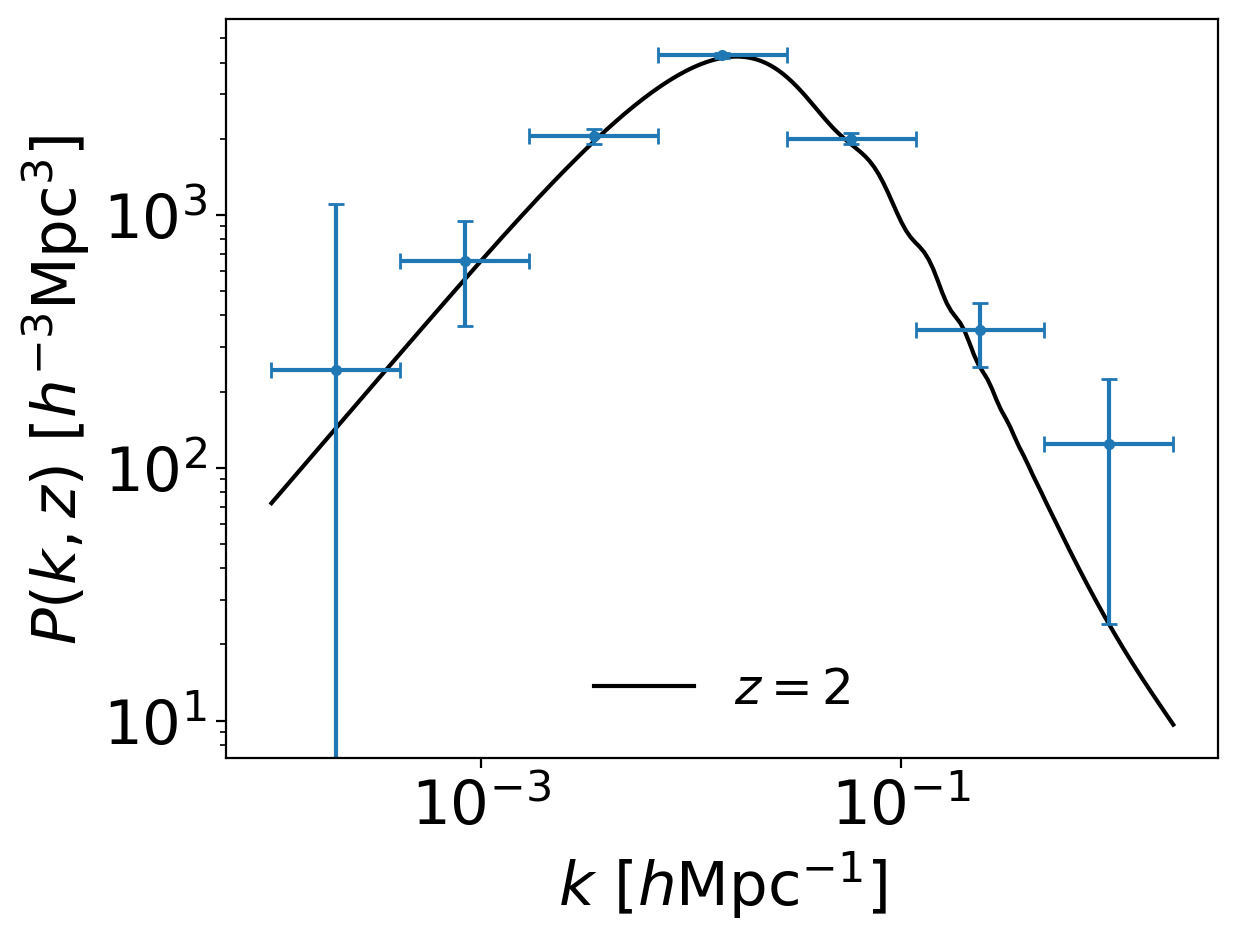

In [7]:
pk_interp = camb.get_matter_power_interpolator(pars_camb, 0, 10)
fig,ax=plt.subplots()
for i, (redshift, line) in enumerate(zip(z,['-','--'])):
    ax.loglog(kh, pk_nonlin[i,:], color='k', ls = line, label=r'$z=%d$'%redshift)
    errorbars = get_Pk_errorbars(k_bins, pk_interp, cosmoParams = pars_camb, surveyParams = surveyParams)
    print(errorbars.shape)
    ax.errorbar(errorbars[0,:], errorbars[1,:], yerr = errorbars[2,:], xerr = [errorbars[3,:],errorbars[4,:]],
                marker='.', ls='none', capsize=3)
ax.set_xlabel(r'$k\,\,[h\mathrm{Mpc}^{-1}]$')
ax.set_ylabel(r'$P(k,z)\,\,[h^{-3}\mathrm{Mpc}^3]$')
ax.legend(frameon=False,fontsize=18)
plt.show()

# Weak lensing angular spectrum

### Non-tomographic power spectra

For the error bars here, we simply use the formula 
$$\sigma_{C_\ell}^2 = \frac{2C_\ell^2}{(2\ell+1)f_{\mathrm{sky}}\Delta\ell}$$
from eq. 10.45 in Dragan's book.

In [8]:
nzs = [jc.redshift.smail_nz(1,2,1)]
probes = [jc.probes.WeakLensing(nzs, sigma_e = .2)]
ell = np.logspace(1,5,100)
cls = jc.angular_cl.angular_cl(pars_jc, ell, probes)

/home/carter/.venv.camb/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


In [9]:
cls.shape

(1, 100)

In [10]:
def get_Cl_errorbars(ell_bins, C_ell, surveyParams):
    dell = ell_bins[1:]-ell_bins[:-1]
    ell_sample = np.floor((ell_bins[1:]+ell_bins[:-1])/2)

    error_y = (2/((2*ell_sample+1)*surveyParams['f_sky']*dell))**.5*C_ell[(ell_sample+1).astype(int)]
    errorbars = np.array([ell_sample, C_ell[(ell_sample+1).astype(int)], error_y, ell_sample[:]-ell_bins[:-1], ell_bins[1:]-ell_sample[:]])
    return errorbars

Text(0.5, 1.0, 'Weak Lensing angular power spectrum')

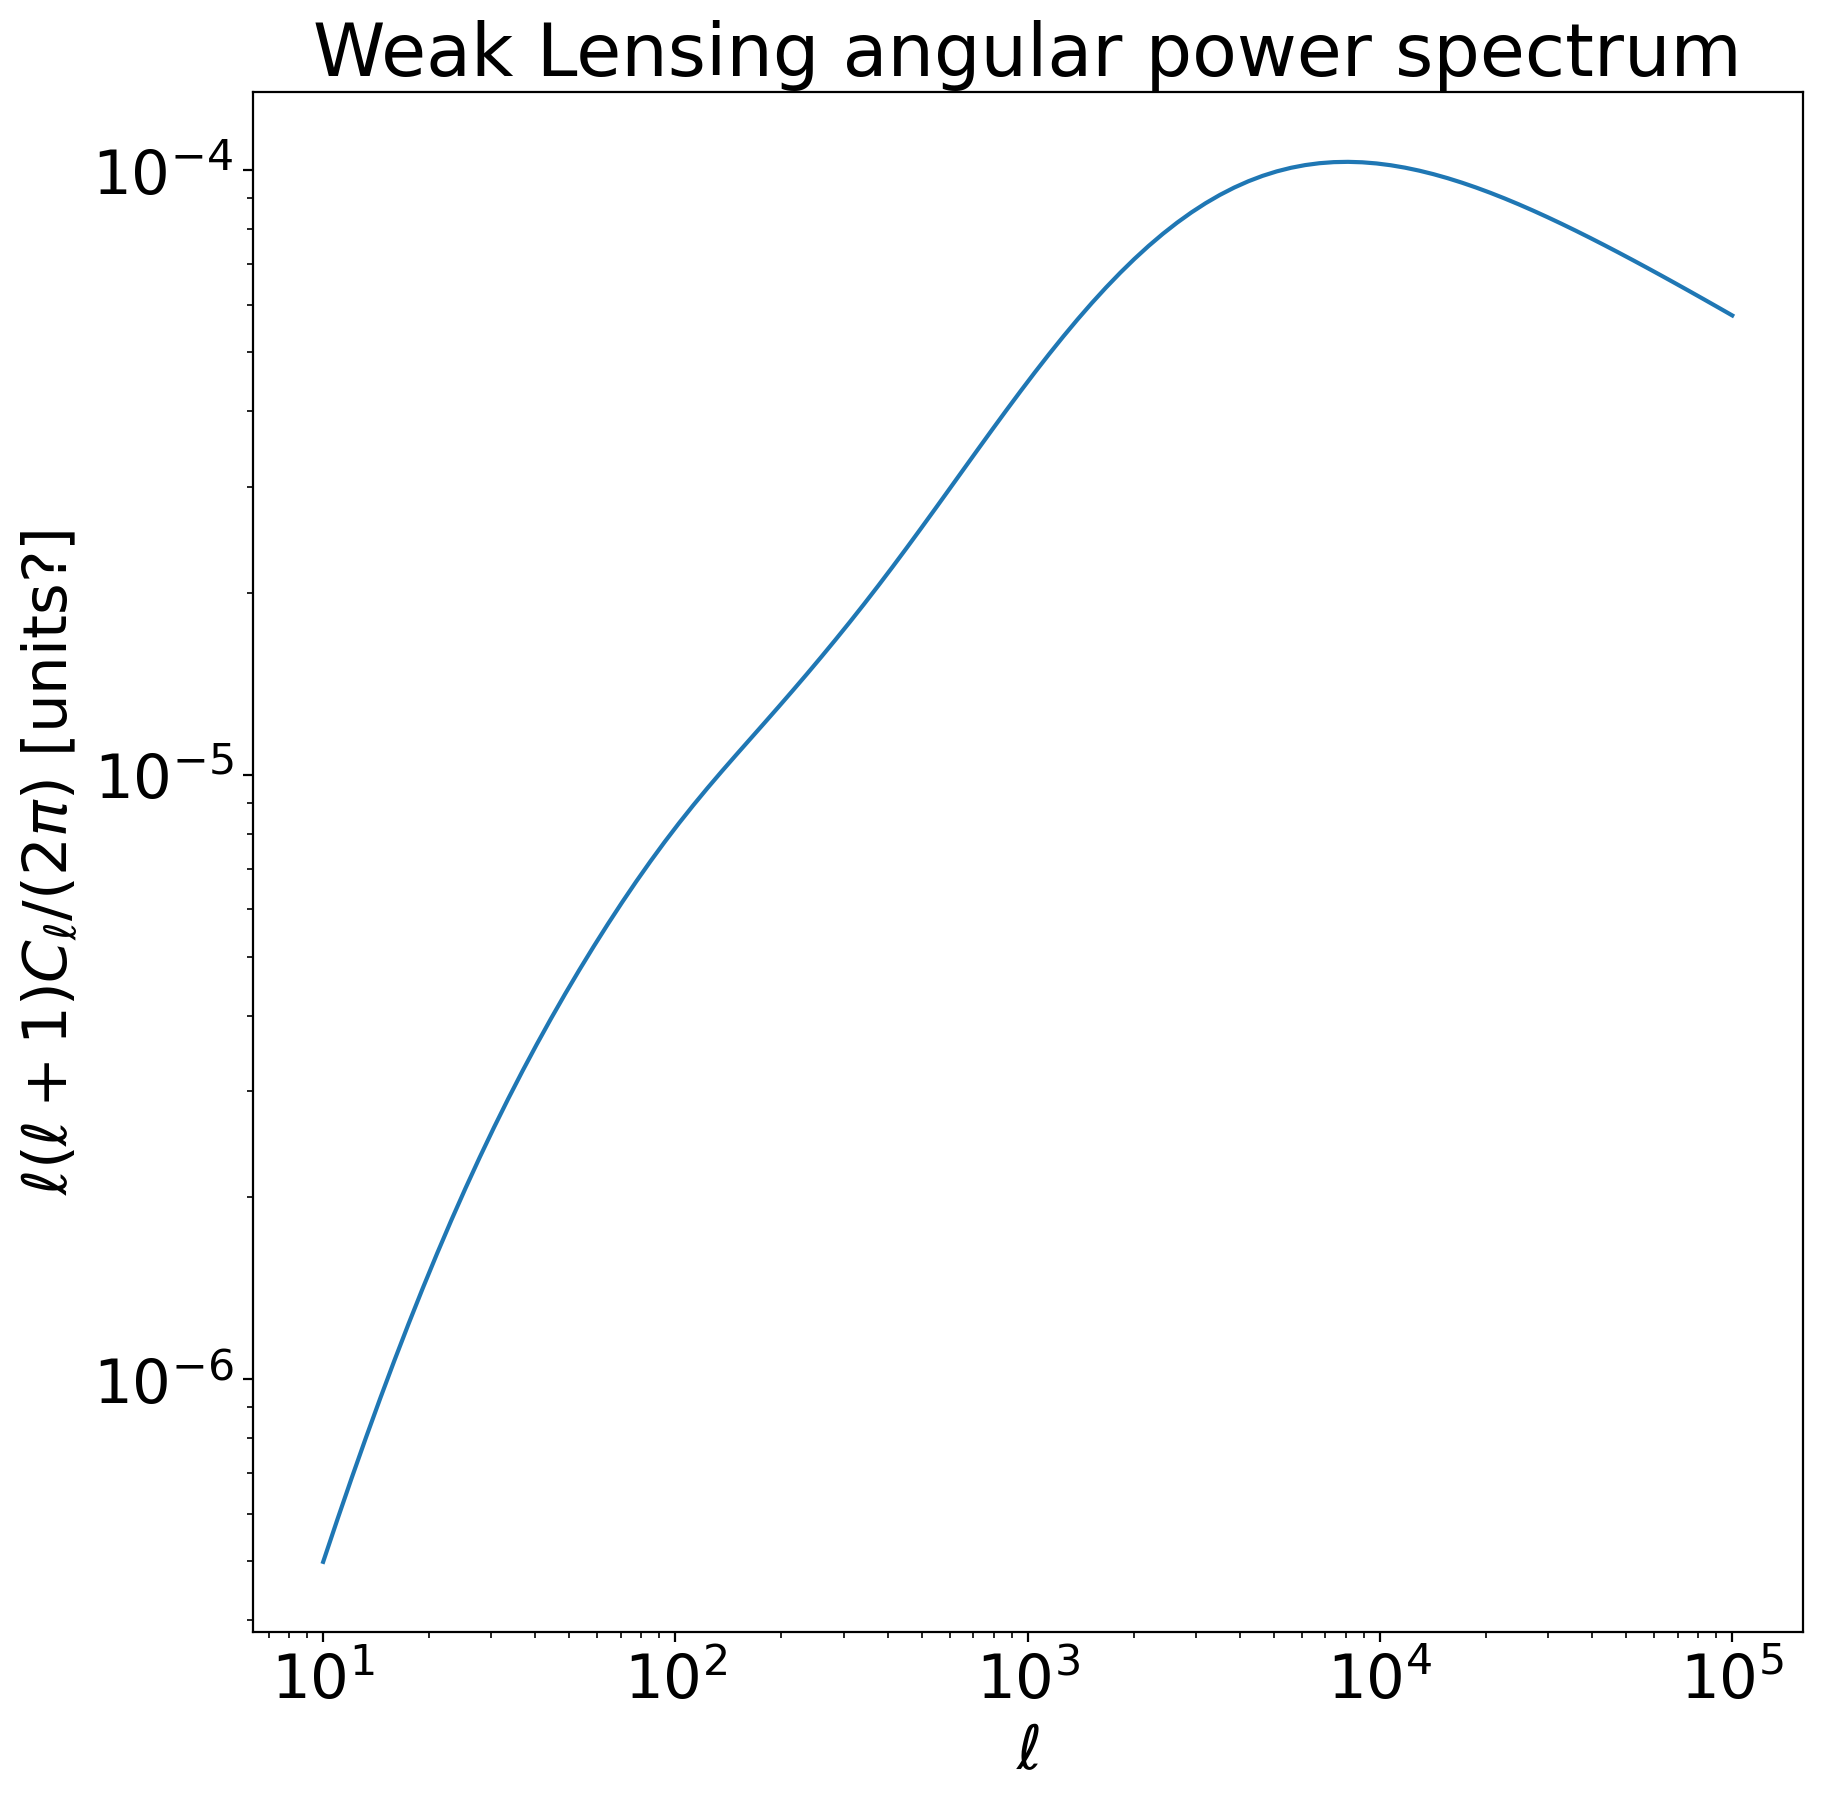

In [11]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.loglog(ell, cls[0]*ell*(ell+1)/(2*math.pi))
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell(\ell+1)C_\ell/(2\pi)$ [units?]')
ax.set_title('Weak Lensing angular power spectrum')

#errorbars = get_Cl_errorbars(np.logspace(1,4, 5), cls[0], surveyParams)
#plt.errorbar(errorbars[0,:], errorbars[1,:], yerr = errorbars[2,:], xerr = [errorbars[3,:],errorbars[4,:]])

In [12]:
#TODO am I using the correct power spectrum?

# CMB Angular power spectrum

In [13]:
def get_CMB_cl_errorbars(ell_bins, Cell, f_sky):
    ell_sample = ((ell_bins[:-1]+ell_bins[1:])*.5)
    dell = ell_bins[1:]-ell_bins[:-1]
    sigma2 = 2/((2*ell_sample+1)*f_sky*dell)*Cell[ell_sample.astype(int)]**2
    error_y = sigma2**.5
    errorbars = np.array([ell_sample, Cell[ell_sample.astype(int)], error_y, ell_sample-ell_bins[:-1], ell_bins[1:]-ell_sample])
    return errorbars

In [14]:
pars_camb.set_for_lmax(2500)
results = camb.get_results(pars_camb)
powers = results.get_cmb_power_spectra(pars_camb, CMB_unit = 'muK')
totCL = powers['total']
ls = np.arange(totCL.shape[0])

Text(0.5, 1.0, 'CMB TT Angular Power Spectrum')

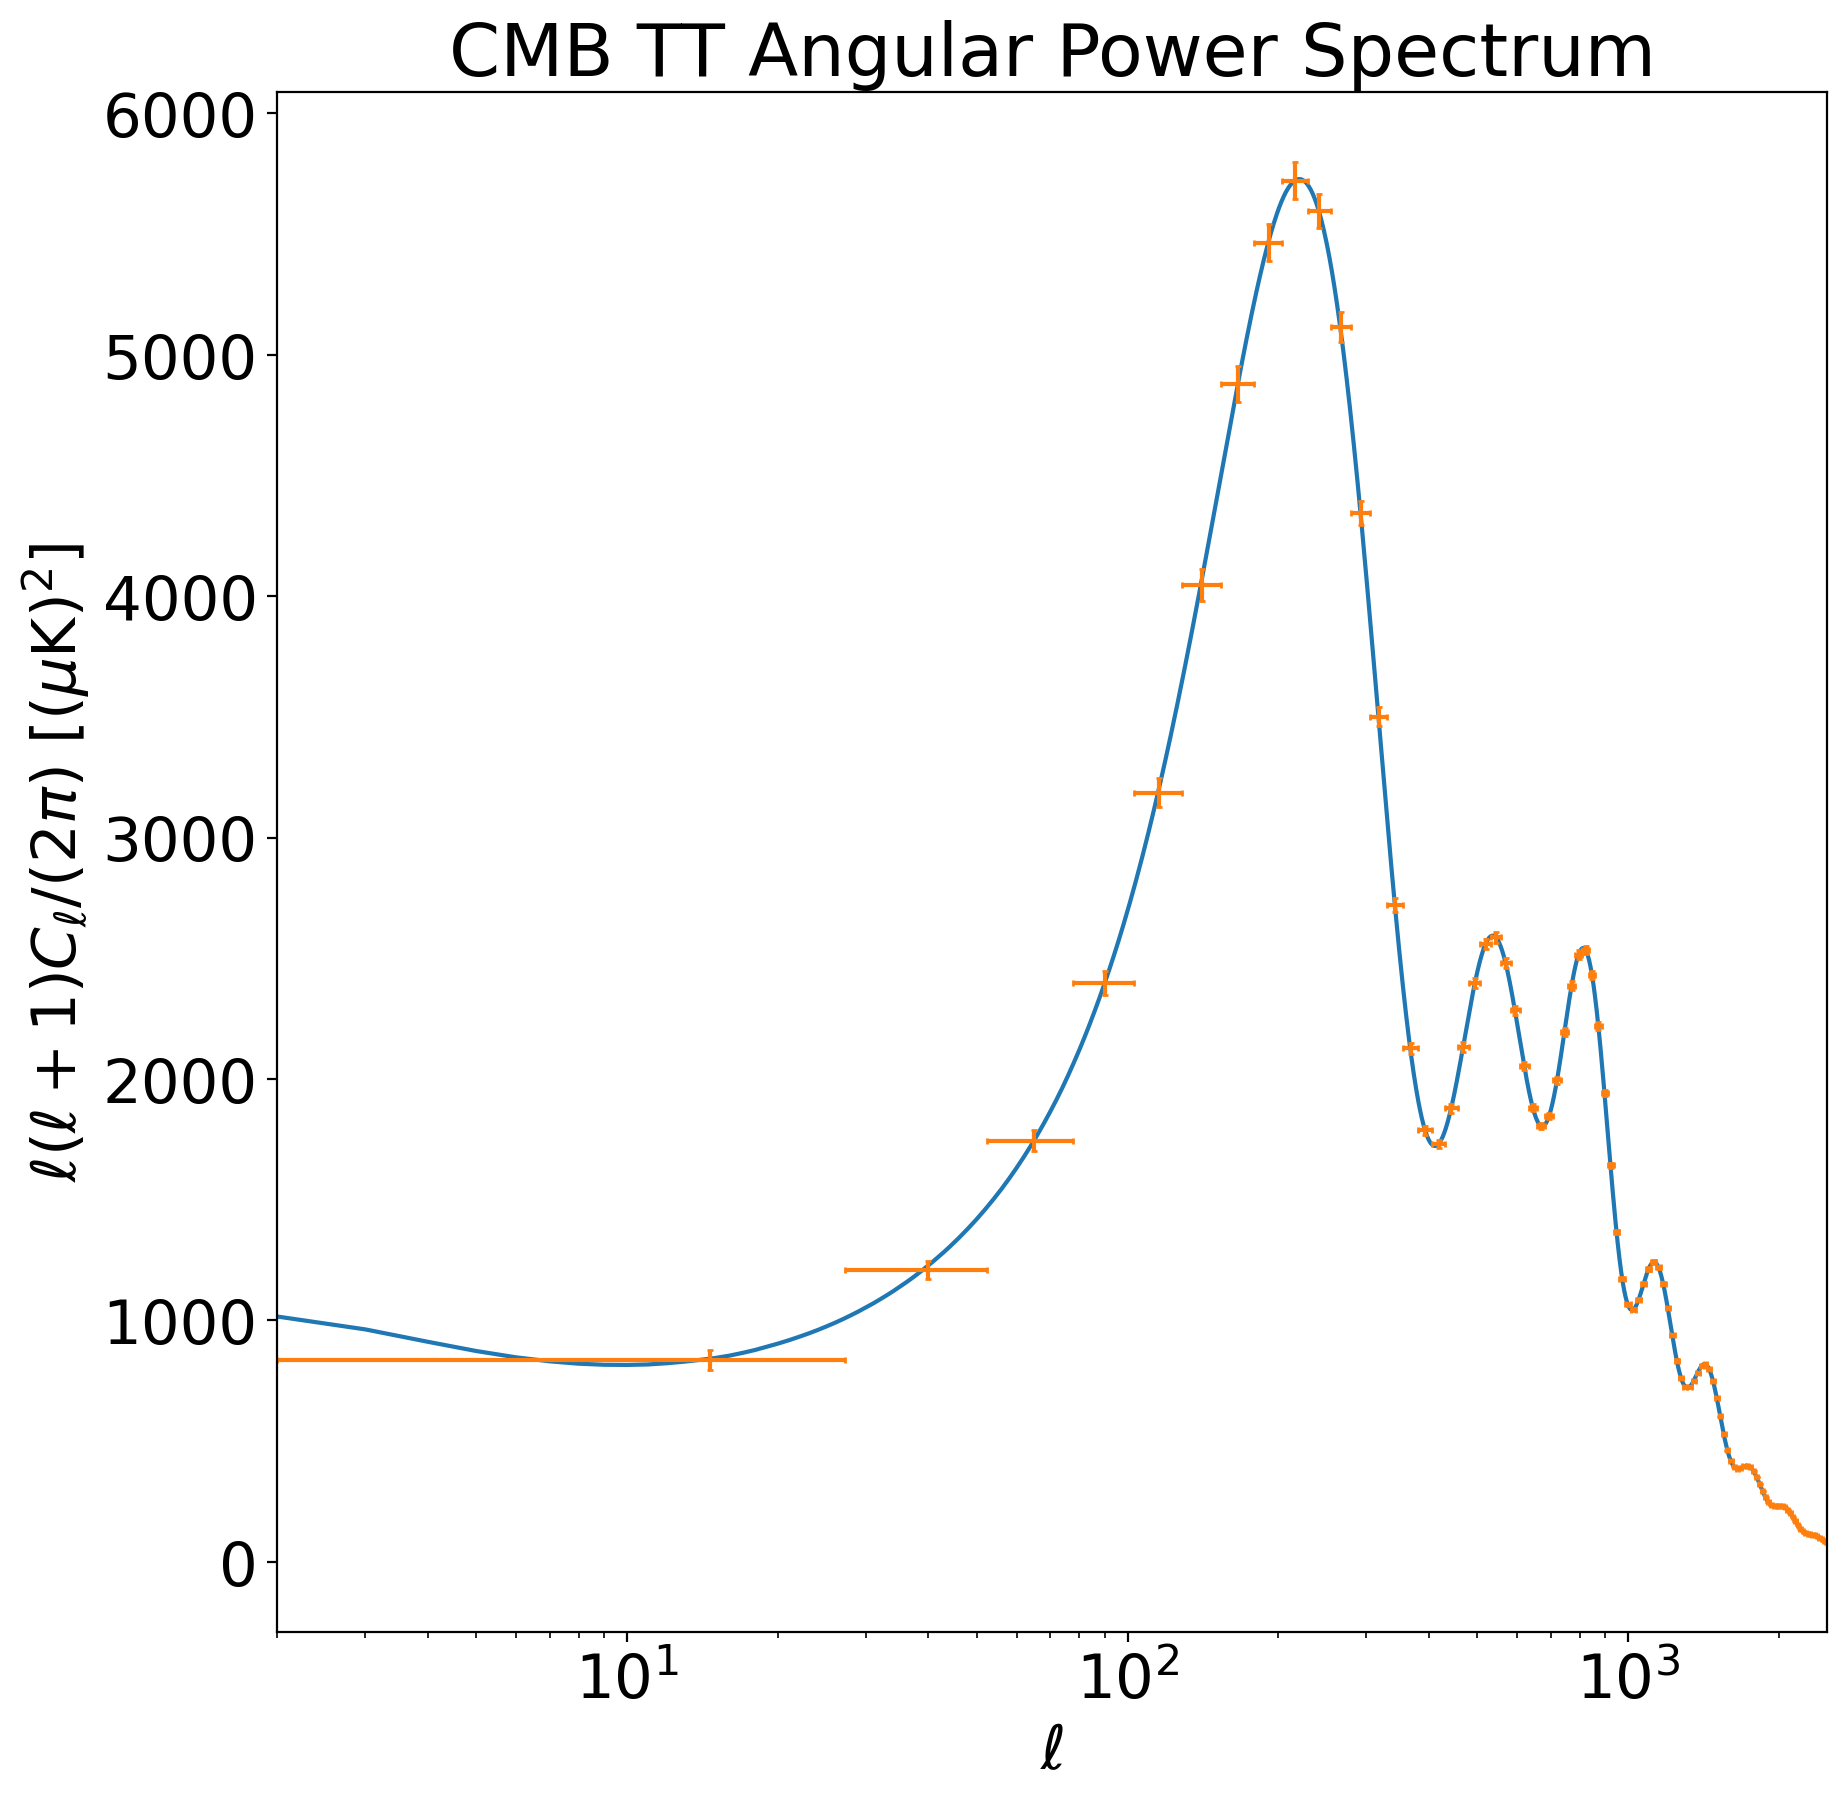

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.semilogx(ls, totCL[:,0])
errorbars = get_CMB_cl_errorbars(np.linspace(2,2500,100),totCL[:,0], 1)
ax.errorbar(errorbars[0],errorbars[1],errorbars[2],[errorbars[3],errorbars[4]], ls = 'none', capsize=1)
ax.set_xlim((2,2500))
ax.set_ylabel(r'$\ell(\ell+1)C_\ell/(2\pi)$ [$(\mu\mathrm{K})^2$]')
ax.set_xlabel(r'$\ell$')
ax.set_title('CMB TT Angular Power Spectrum')

In [16]:
print(errorbars.shape)

(5, 99)
